# Site Analysis

This is the notebook with all the code used to create the various plots used in our analysis of grailed.com. This is not meant to be read on its own, it's just to keep the code public for those that are curious or dubious. However, we have dumped some of our initial thoughts into Markdown cells throughout the notebook. There's also far more plots here.

Also, feel free to [send us an email](mailto:kennzoid@gmail.com) if you have suggestions or errors to report.

## Setup

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotSlope

from IPython.display import display, Image, HTML

plt.style.use('ggplot')

In [3]:
listings_df = pd.read_csv('../scraper/create_dataset/listings.csv')
users_df = pd.read_csv('../scraper/create_dataset/users.csv')
listing_user_follow_df = pd.read_csv('../scraper/create_dataset/listing_user_follow.csv')
photos_df = pd.read_csv('../scraper/create_dataset/photos.csv')

In [4]:
listings_df.index = listings_df['id']
listings_df['created_at'] = pd.DatetimeIndex(pd.to_datetime(listings_df['created_at'] , format='%Y-%m-%d %H:%M:%S.%f'))
listings_df['created_at_date'] = listings_df['created_at'].dt.date
listings_df['created_at_month'] = listings_df['created_at'].dt.month
listings_df['sold_at'] = pd.to_datetime(listings_df['sold_at'])
listings_df['sold_at_day_of_week'] = listings_df['sold_at'].dt.dayofweek
listings_df['sold_at_hour'] = listings_df['sold_at'].dt.hour
listings_df['sold_at_date'] = listings_df['sold_at'].dt.date

## Dataset Info

This is some background on the data we scraped. Our data spans about 2 years and 6 months. This is a pretty sizeable amount of data! 

We iteratively scraped listing data first, which contained most of what we needed for this notebook. We also scraped user data because we needed to know what listings each user was following to perform collaborative filtering in another notebook. We did not scrape photos because of financial and technical limitations, but that's something we're hoping to toy with in the future.
***

In [12]:
print 'Max Listing ID: {}'.format(max(listings_df['id']))
print 'Max User ID: {}'.format(max(users_df['id']))
print 'Latest Creation Time: {}'.format(max(listings_df['created_at']))
print 'Earliest Creation Time: {}'.format(min(listings_df['created_at']))

Max Listing ID: 562983
Max User ID: 252164
Latest Creation Time: 2016-05-12 21:40:12.012000
Earliest Creation Time: 2013-12-12 22:14:13.770000


In [425]:
print 'Number of listings: {}'.format(len(listings_df))
print 'Number of users: {}'.format(len(users_df))
print 'Number of photos: {}'.format(len(photos_df))

Number of listings: 306720
Number of users: 249427
Number of photos: 1377154


## Growth

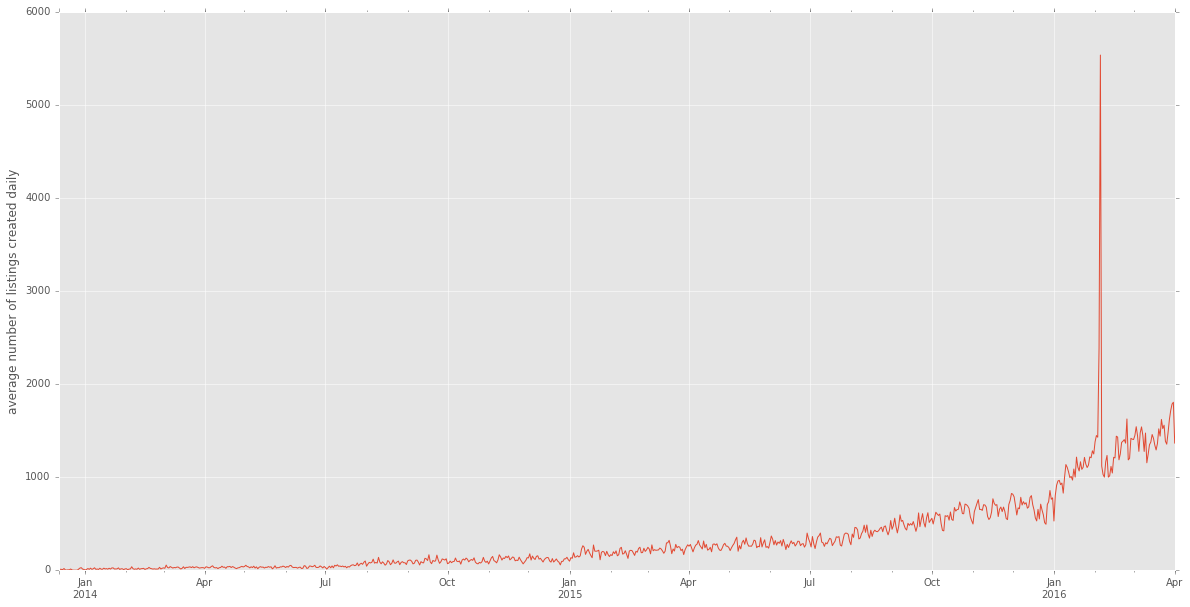

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
global_volume_over_time = listings_df.groupby(pd.Grouper(key='created_at', freq='1d')).size()
global_volume_over_time[:pd.Timestamp('2016-04-01 00:00:00')].plot()
ax.set_ylabel('average number of listings created daily')
ax.set_xlabel('')

In [196]:
display(str(global_volume_over_time.idxmax()))
display(max(global_volume_over_time))

'2016-02-05 00:00:00'

5539

In [197]:
np.mean(global_volume_over_time[(global_volume_over_time.index > '2016-03-01') & (global_volume_over_time.index < '2016-04-01')])

1458.6333333333334

In [11]:
np.mean(global_volume_over_time[(global_volume_over_time.index > '2015-03-01') & (global_volume_over_time.index < '2015-04-01')])

232.19999999999999

Profit After Fee Increase (from Feb-02-2016 until May-01-2016)

In [198]:
np.sum(listings_df[listings_df['created_at'] > '2016-02-05']['sold_price']) * 0.06

423343.07999999996

***
This plot shows listing volume added daily. As you can tell, Grailed has been growing very steadily since its inception in 2013. The site averaged ~1459 new listings per day in March 2016. That's awesome, considering a year earlier that number was ~232.

The giant spike in the plot is due to grailed increasing their seller fees. Many sellers decided to list all their items before that day in order to avoid that. There were 5539 listings created that day.

After the fee increase they earned $423,343.08, assuming they take 6% of the sale, PayPal takes 3% and that we scraped everything correctly. 

## User Stats

#### Location distribution

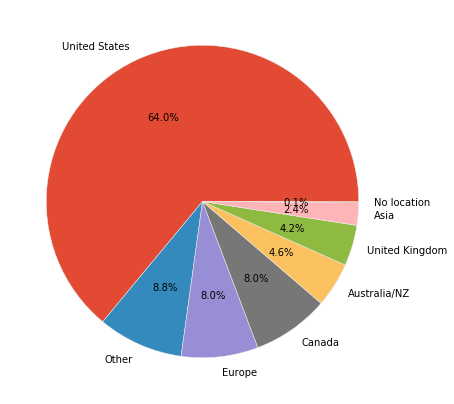

In [199]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
users_df.groupby('location').size().sort_values(ascending=False)[:8].plot(kind='pie', autopct='%1.1f%%')
ax.set_xlabel('')
ax.set_ylabel('')

***
No real surprises here. Canada and Australia do seem kind of small considering how many times I've been asked to ship there...

#### Top sellers

In [202]:
sold_listings = listings_df[listings_df['sold'] == 1]
grouped_sellers = sold_listings.groupby('seller_id')
seller_sums = grouped_sellers.sum()

top_seller_data = {
    'username': [users_df[users_df['id'] == id]['username'].values[0] for id in seller_sums.index],
    'gross earnings': seller_sums['sold_price'],
    'listings sold': grouped_sellers.size(),
    'earliest listing': [min(listings_df[listings_df['seller_id'] == id]['created_at_date']) for id in seller_sums.index],
    'latest listing': [max(listings_df[listings_df['seller_id'] == id]['created_at_date']) for id in seller_sums.index],
}

sellers_df = pd.DataFrame(top_seller_data, columns=['username', 'listings sold', 'gross earnings', 'earliest listing', 'latest listing'])
ordered_sellers_df = sellers_df.sort_values(by='gross earnings', ascending=False)

ordered_sellers_df['gross earnings'] = ordered_sellers_df['gross earnings'].map('${}'.format)
ordered_sellers_df.index.name = None
ordered_sellers_df.head(20)

,username,listings sold,gross earnings,earliest listing,latest listing
952,slvrain,328,$111998,2014-06-27,2016-04-24
895,god,254,$89192,2014-02-09,2016-04-08
9621,viadeiservi,206,$77714,2015-04-04,2016-04-17
16610,tigerblood,116,$61499,2014-09-27,2016-02-04
71378,maahno,83,$60877,2015-08-09,2016-05-11
6011,inmamy,422,$60572,2014-04-18,2016-03-07
8326,redesignered,327,$52631,2014-07-15,2016-04-27
65043,carlosxantana,104,$49901,2015-07-12,2016-04-10
23,Garmentist,301,$49606,2014-02-22,2016-04-11
235,trunks,284,$47288,2015-03-14,2016-04-28


***
Many of you will probably recognize some of these users; these are the top 20 sellers by gross earnings. 

#### Mean/Median of Money Spent and Money Earned

In [203]:
earnings_per_user = listings_df[listings_df['sold'] == 1].groupby('seller_id').sum()['sold_price'].values
print 'Mean gross earnings: {}\nMedian gross earnings: {}'.format(np.mean(earnings_per_user), np.median(earnings_per_user))

Mean gross earnings: 1001.67444758
Median gross earnings: 370.0


In [204]:
spending_per_user = listings_df[listings_df['sold'] == 1].groupby('buyer_id').sum()['sold_price'].values
print 'Mean spending: {}\nMedian spending: {}'.format(np.mean(spending_per_user), np.median(spending_per_user))

Mean spending: 572.465833505
Median spending: 240.0


#### Most Earned/Spent On A Single Listing Per User

In [205]:
user_max_spendings = listings_df[['buyer_id', 'sold_price']].groupby('buyer_id').max()
print 'Mean max spending: {}\nMedian max spending: {}'.format(np.mean(user_max_spendings['sold_price']), np.median(user_max_spendings['sold_price']))

Mean max spending: 223.422870098
Median max spending: 160.0


In [206]:
user_max_earnings = listings_df[['seller_id', 'sold_price']].groupby('seller_id').max()
print 'Mean max earning: {}\nMedian max earning: {}'.format(np.mean(user_max_earnings['sold_price']), np.median(user_max_earnings['sold_price']))

Mean max earning: 199.510874693
Median max earning: 130.0


***
This suggests that the majority of users have spent over $160 on a single item. That's really cool, it means that Grailed is realizing its goal of being a marketplace for people that are more interested in fashion than the average person.

## Designer Stats

#### First, let's limit the designers to only those with a significant number of listings.

In [20]:
designer_counts = listings_df.groupby('designer_name').size().sort_values(ascending=False)
designers_of_interest = list(designer_counts[designer_counts > 1000].index)

#### Top Designers (Aggregated Over All Scraped Data)

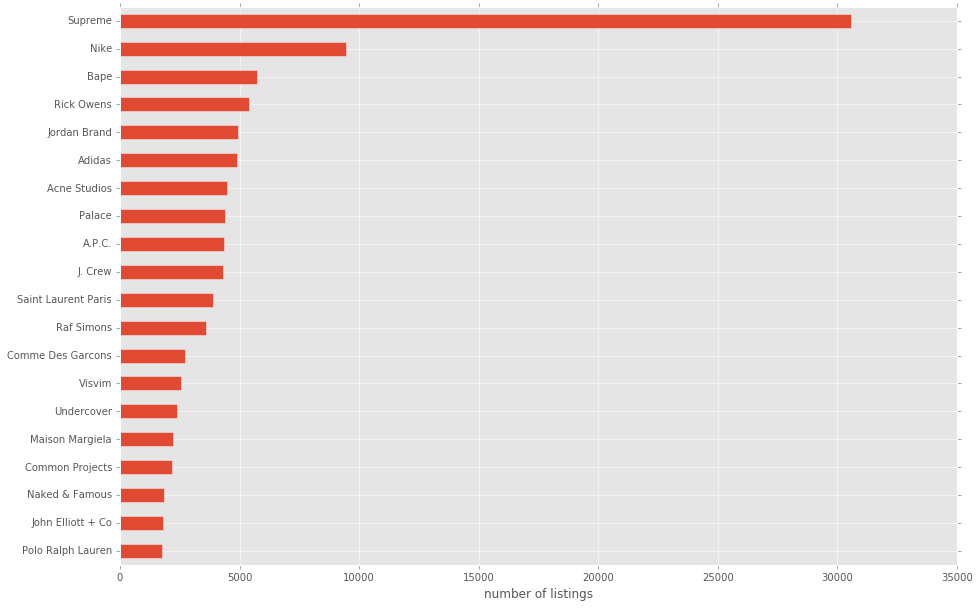

In [211]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sorted_designer_counts = designer_counts.sort_values(by='id')
sorted_designer_counts['id'][-20:].plot(kind='barh')
ax.set_xlabel('number of listings')
ax.set_ylabel('')

***
The amount of Supreme listings on Grailed is pretty disproportional. Users that were around before Supreme got separated into the 'hype' section of Grailed will remember the feed being flooded by Supreme listings. I believe there is an extension that omits Supreme listings because of how annoying this is.

#### Bump Plot

In [212]:
# this creates a df indexed on the designer name and 3 month buckets, where the cell indicates 
# how many listings were created during that range of time
designer_3m_counts = listings_df.groupby(['designer_name', pd.TimeGrouper(key='created_at', freq='6M')]).size()

# selecting id is arbitrary, we just want any count of unique listings
# unstacking converts the secondary index into columns (kind of)
unstacked_designer_3m_counts = designer_3m_counts.unstack()

# limit to designer of interest
doi_3m_counts = unstacked_designer_3m_counts.loc[designers_of_interest[:20]]
doi_3m_counts = doi_3m_counts.fillna(0)

In [213]:
doi_3m_counts_no_ends = doi_3m_counts.drop(doi_3m_counts.columns[[0]], axis=1)

In [214]:
doi_3m_counts_no_ends.loc['Undercover']['2014-06-30 00:00:00'] += 1

In [222]:
plt.style.use('ggplot')
color_list = plt.rcParams['axes.color_cycle']*2 + plt.rcParams['axes.color_cycle'][:6]
colors = {designer: color for designer, color in zip(designers_of_interest[:20], color_list)}

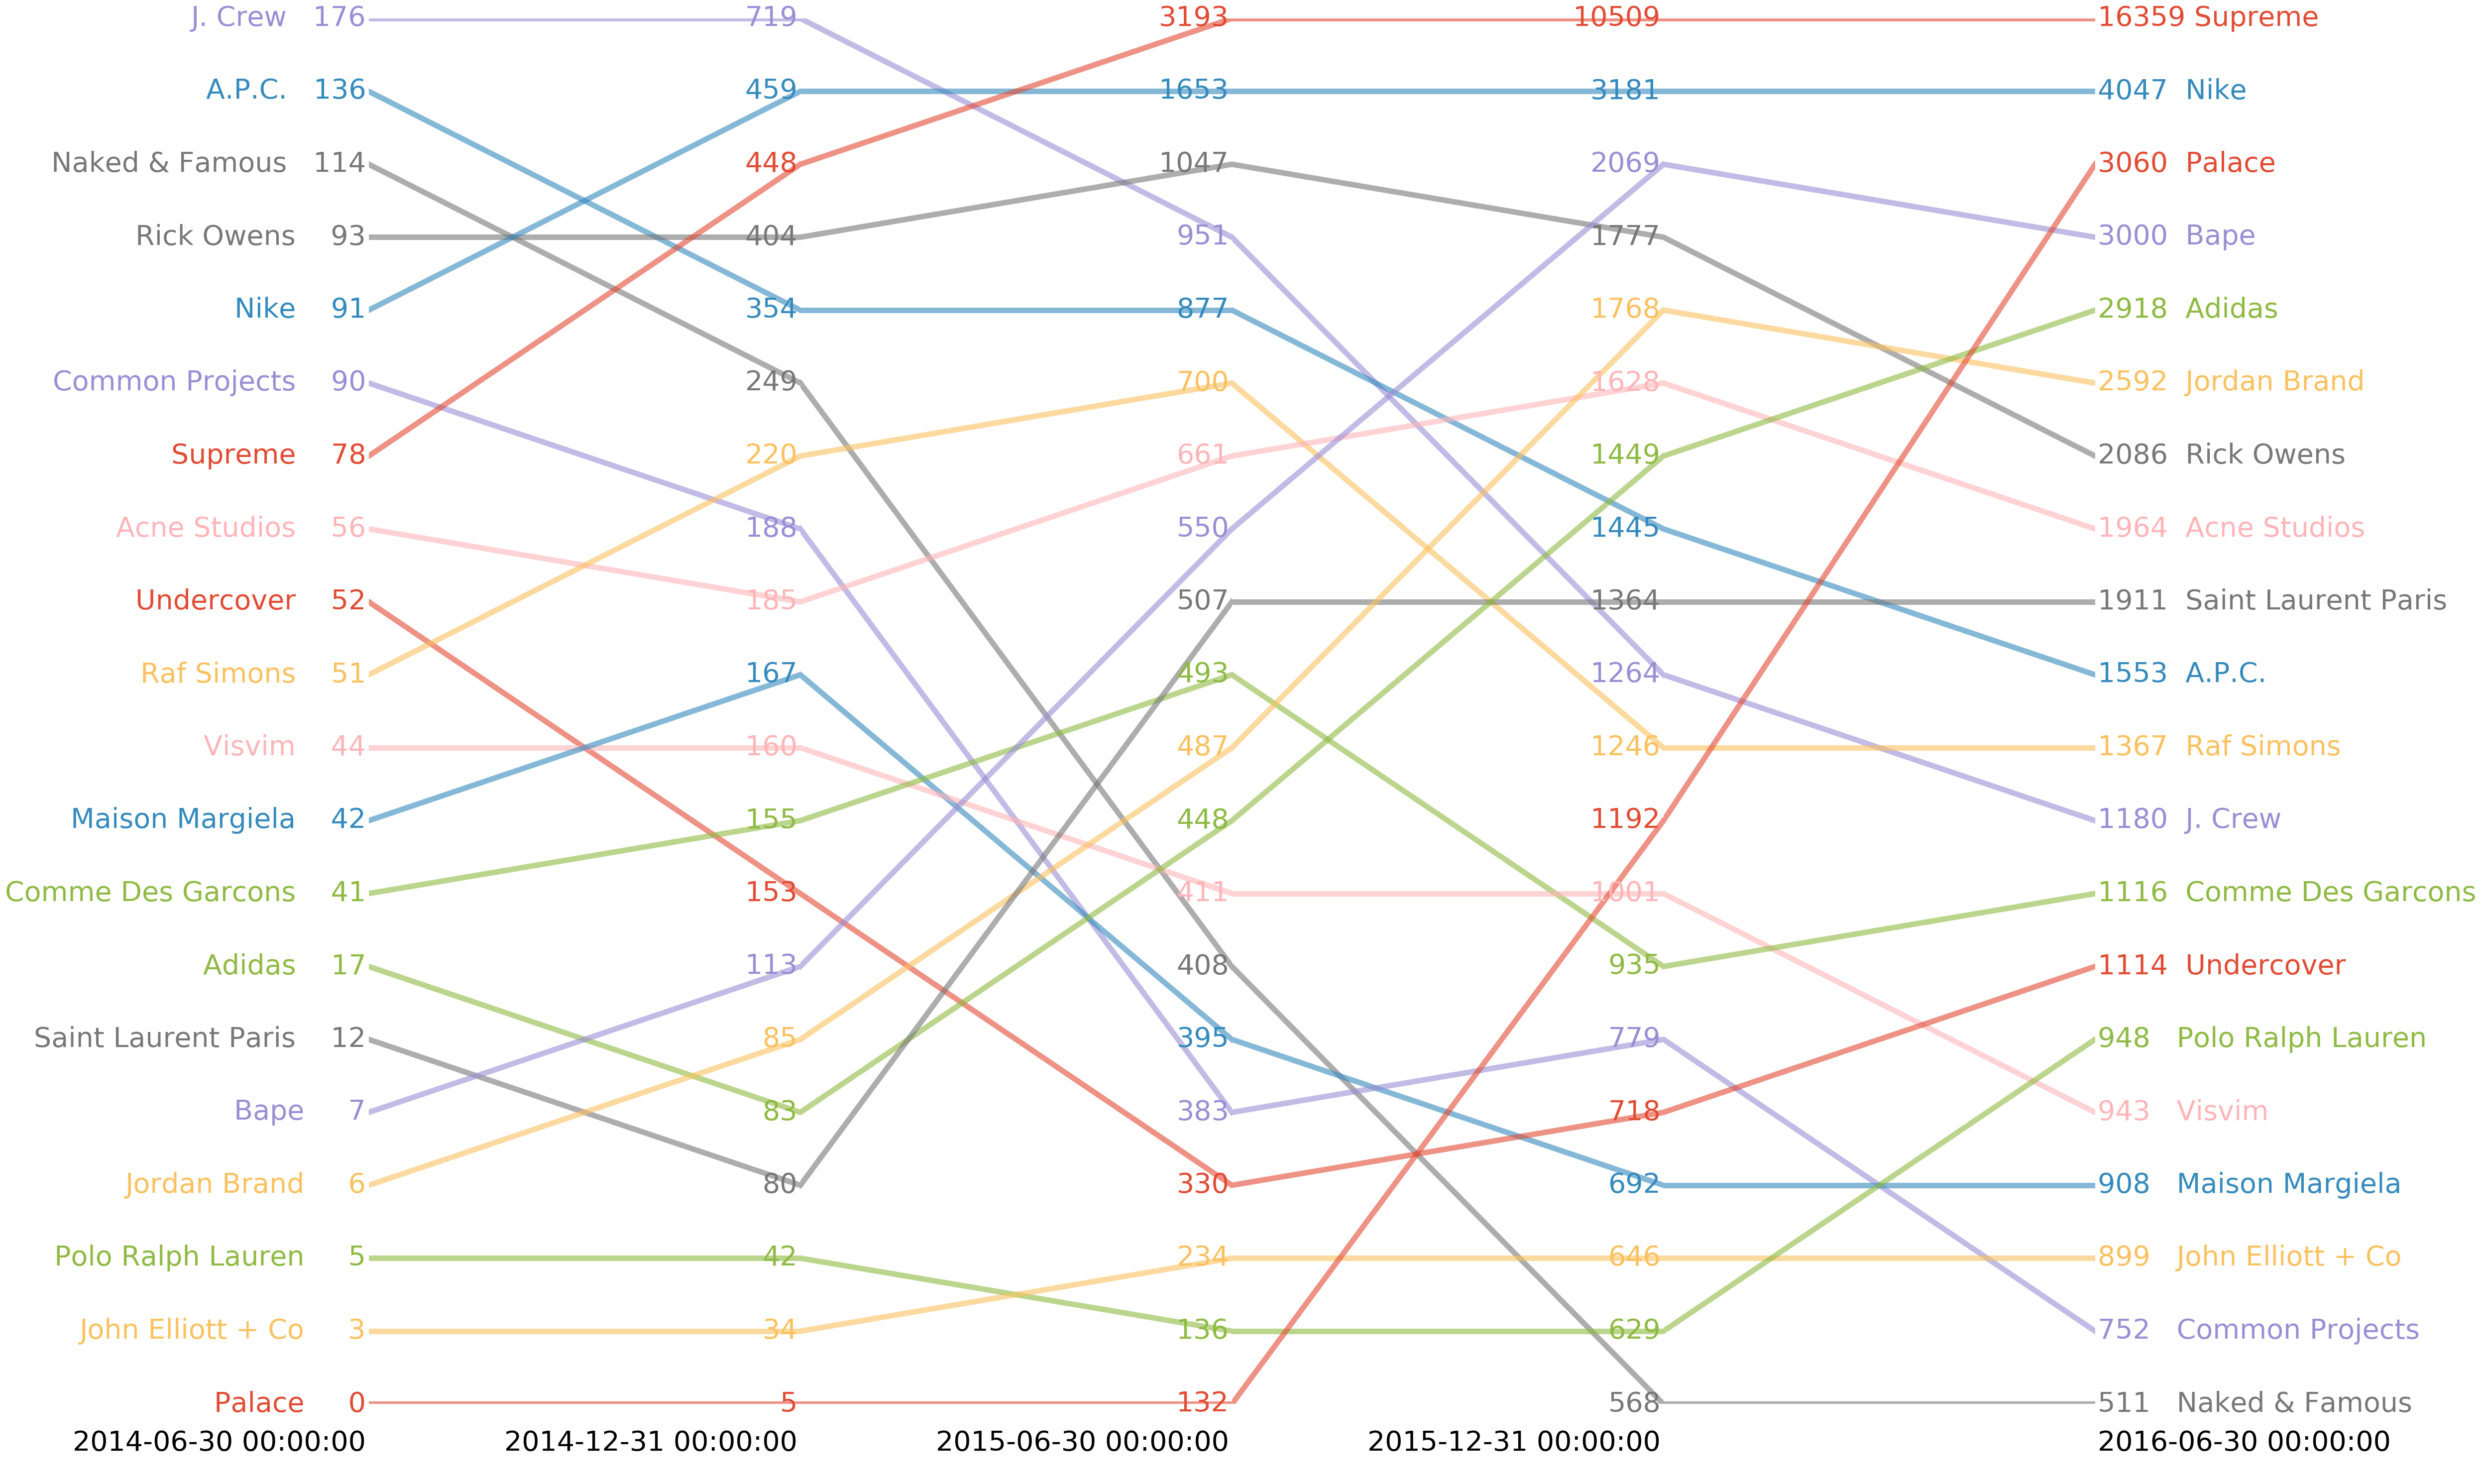

In [216]:
plt.style.use('default')
f = plotSlope.slope(doi_3m_counts_no_ends, kind='ordinal', height=30, width=50, font_size=40, title = '', color=colors)

***
This is an admittedly difficult plot to read at first. It basically shows the relative ordering of designers by number of listings created within 6 month intervals.

For example, between the beginning of Grailed and 2014-06-30, there were 176 J.Crew listings created (see top left of plot). If you trace that purple line you will see that in the next 6 months, 719 J.Crew listings were created and J.Crew remained the highest volume designer for that interval. Tracing the purple line further you will notice that Supreme and Nike managed to surpass J.Crew in volume in the next 6 months.

Some designers I found interesting to trace were Naked & Famous, Palace, Adidas, and Saint Laurent Paris. Raw denim definitely had a peak of interest 1-2 years back and the brand Naked & Famous was a very popular and accessible raw denim brand. Relative to the other designers, the brand hasn't really maintained the same level of volume (it even decreases at the end, while every other designer has been growing with Grailed). Palace has risen tremendously, which makes sense because it is a very hype-driven brand that has broken into popularity recently. Adidas has definitely become more popular again lately. Saint Laurent Paris makes sense as well (how many times have you heard about the SLP aesthetic this year).

We were hoping to show some of the popularity trends and how things have changed over the years. The original goal was to utilize the scraped data to perform some kind of trend forecasting, but there's an intrinsic flaw in using data from a _secondhand_ market. So this retrospective plot will suffice for now. :P

#### Rate of Sale

In [217]:
delta_to_seconds = lambda x: x.total_seconds()
listings_df['sale_delta'] = listings_df['sold_at'] - listings_df['created_at']
listings_df['sale_delta_seconds'] = listings_df['sale_delta'].apply(delta_to_seconds)
listings_df['sale_delta_days'] = listings_df['sale_delta_seconds']/86400
sold_listings = listings_df[listings_df['sold'] == 1]

In [218]:
print 'Half of listings sold within {:.0f} days'.format(np.nanmedian(listings_df['sale_delta_days']))

Half of listings sold within 9 days


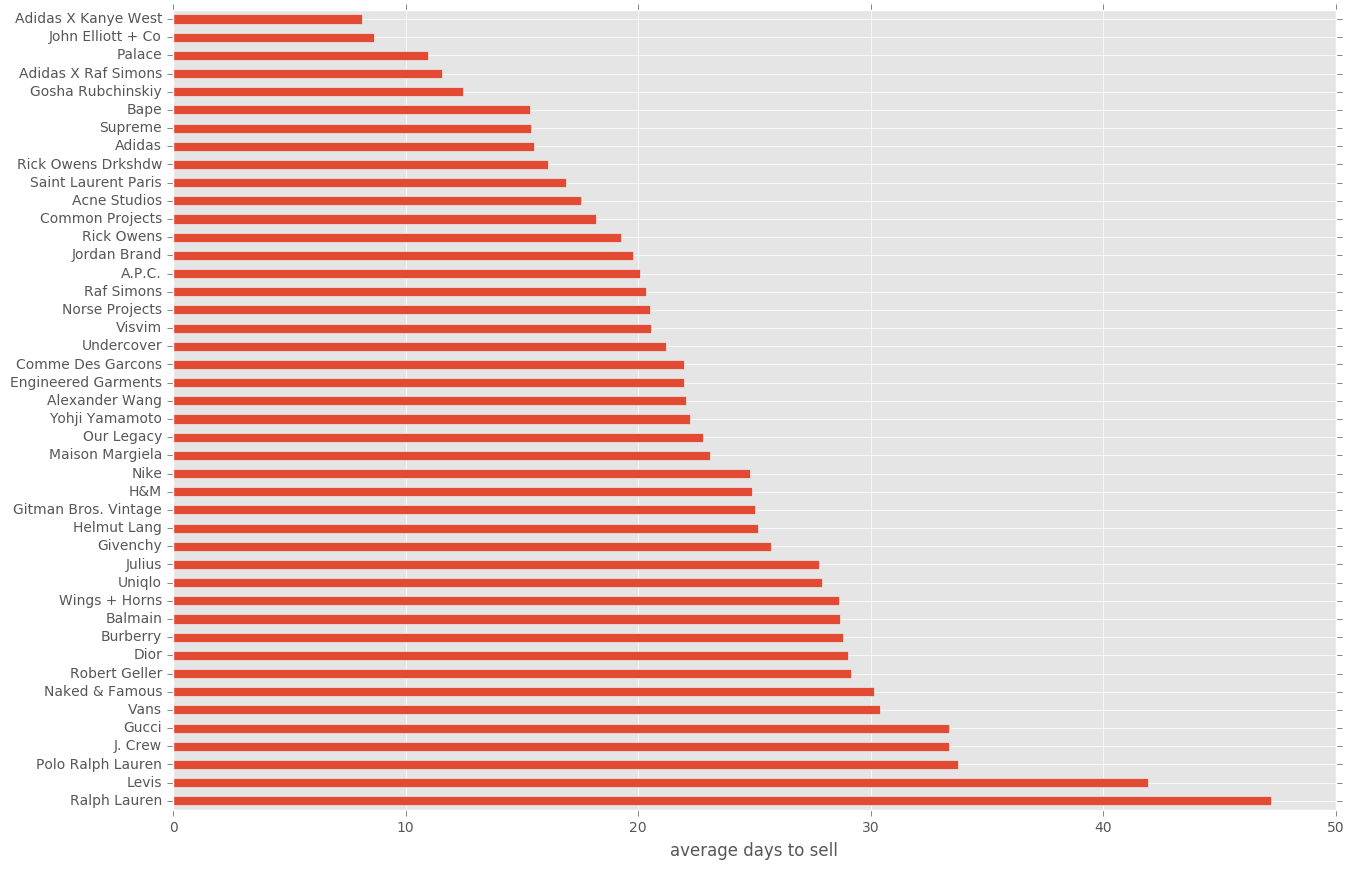

In [224]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
designer_averages = sold_listings.groupby('designer_name').mean()
designer_averages.loc[designers_of_interest]['sale_delta_days'].sort_values(ascending=False).plot(kind='barh')
ax.set_ylabel('')
ax.set_xlabel('average days to sell')

***
Hype brands (pretty much all selling within 20 days) seem to go very quickly while mall brands sit for a while (Ralph Lauren taking over 40 days to sell on average). 

#### Average Price

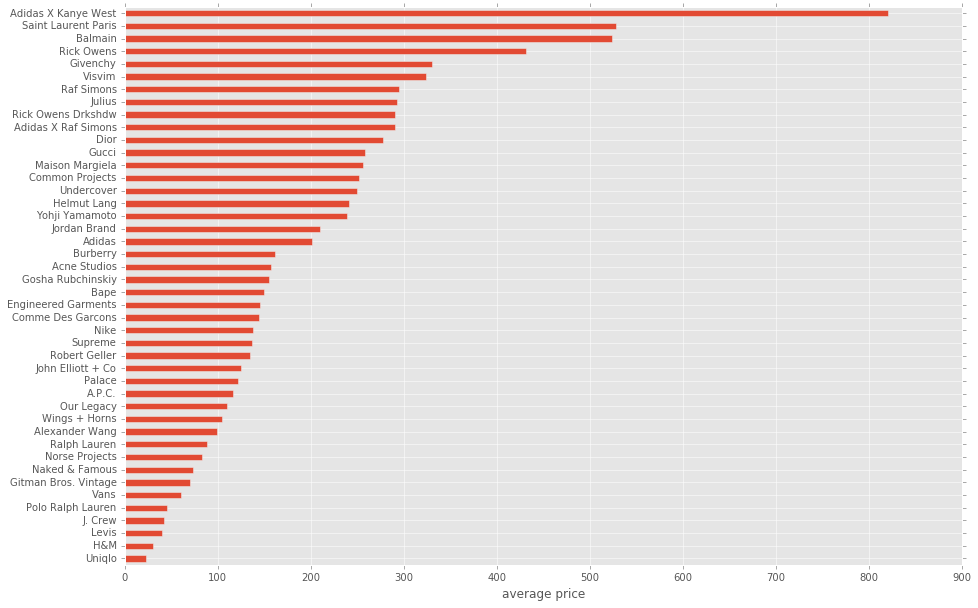

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
doi_averages = listings_df.groupby('designer_name').mean().loc[designers_of_interest]
sorted_doi_averages = doi_averages.sort_values(by='price')
sorted_doi_averages['price'].plot(kind='barh')
ax.set_xlabel('average price')
ax.set_ylabel('')

***
This doesn't _quite_ match up with their retail prices. Maybe we can look into this later.

#### Average Follower Count

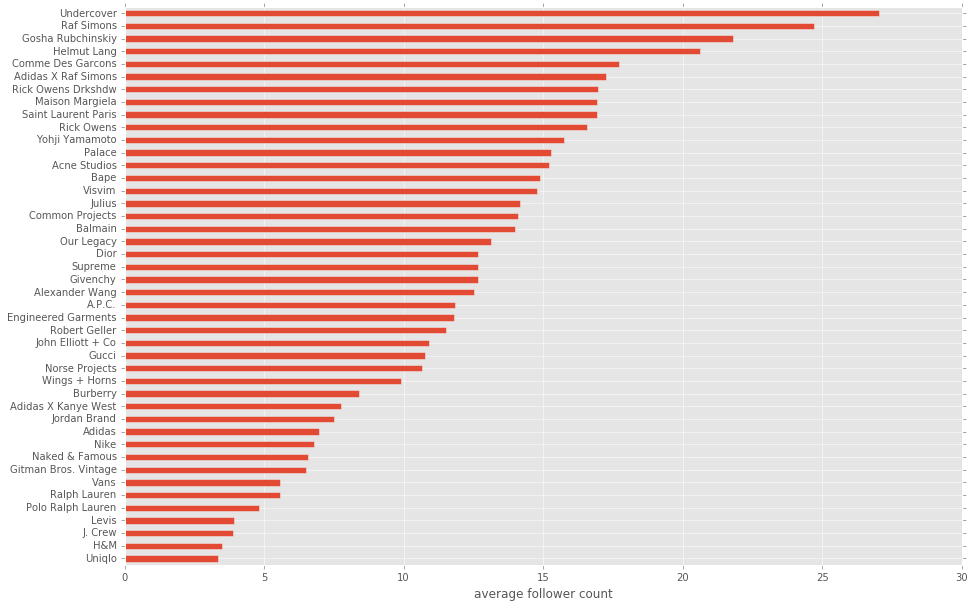

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sorted_doi_averages = doi_averages.sort_values(by='follower_count')
sorted_doi_averages['follower_count'].plot(kind='barh')
ax.set_xlabel('average follower count')
ax.set_ylabel('')

***
There are _so_ many Raf and Undercover listings with a hoard of followers.

## Pricing Stats

#### Lowballing

Lowballing refers to users buying an item for far below its listed price.
***

In [5]:
def price_plus_ship(price, ship_cost):
    if np.isnan(ship_cost):
        return price
    return price + ship_cost

def inf_to_zero(num):
    if np.isinf(num):
        return 0.0
    return num

listings_df['price_plus_ship'] = np.vectorize(price_plus_ship)(listings_df['price'], listings_df['ship_cost'])
listings_df['lowball_amount'] = listings_df['price_plus_ship'] - listings_df['sold_price']
listings_df['percent_price_lowball'] = listings_df['sold_price']/listings_df['price_plus_ship']
listings_df['percent_price_lowball'] = listings_df['percent_price_lowball'].apply(inf_to_zero)
sold_listings = listings_df[listings_df['sold'] == 1]

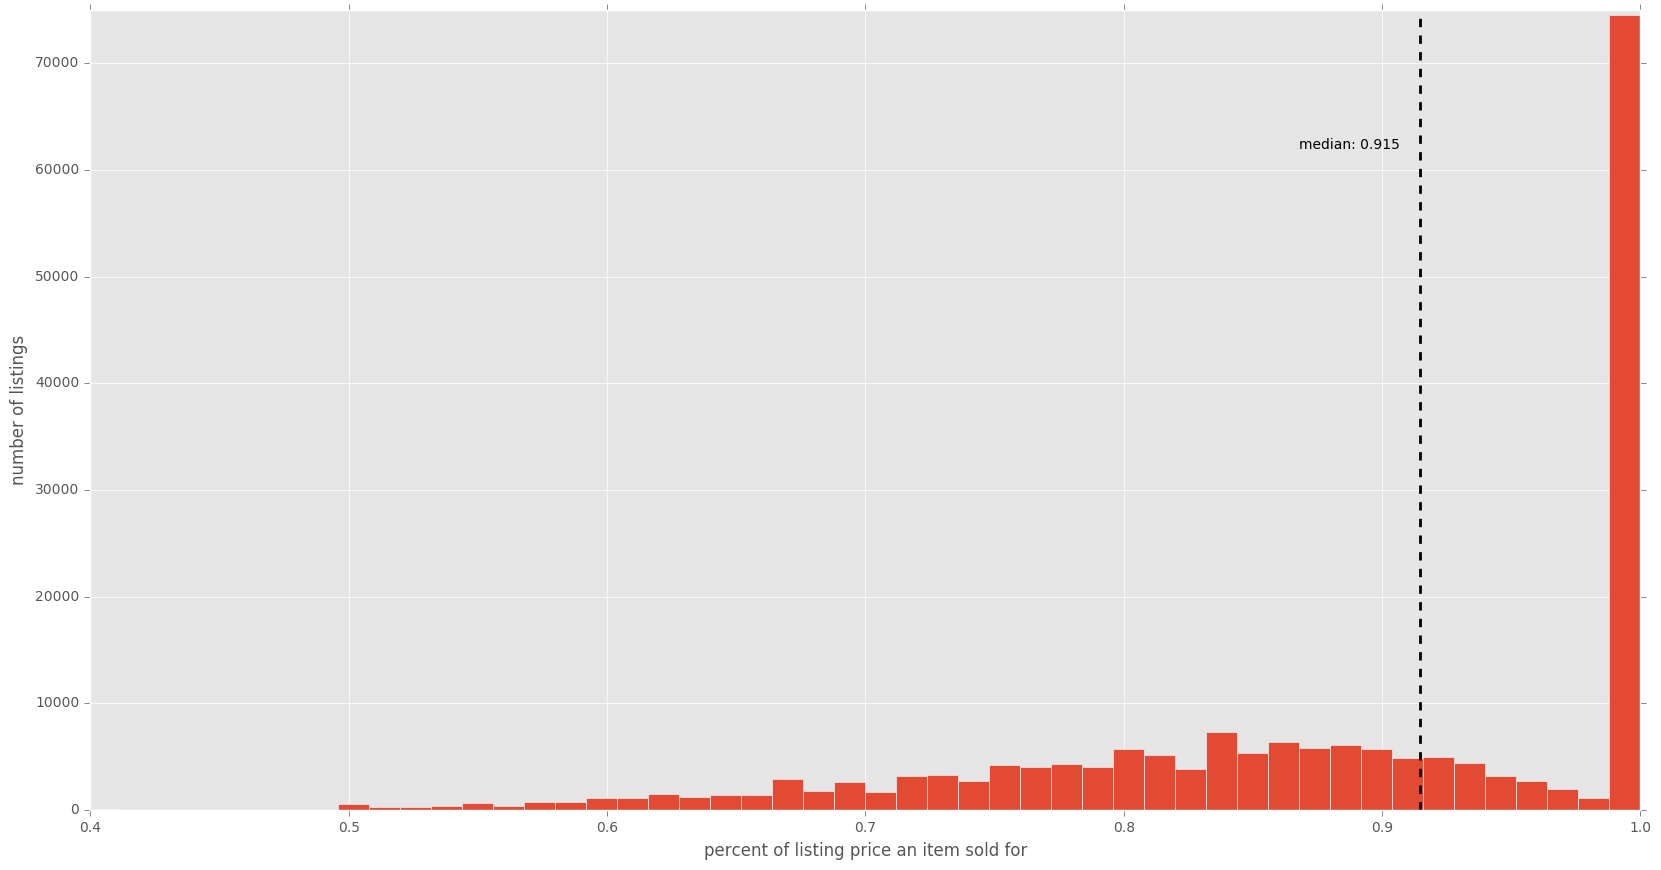

In [227]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sold_listings['percent_price_lowball'].hist(range=[0.4, 1.0], bins=50)
ax.set_ylim([0, 75000])
ax.set_xlabel('percent of listing price an item sold for')
ax.set_ylabel('number of listings')

# draw median
percent_price_lowball_median = np.nanmedian(sold_listings['percent_price_lowball'])
plt.axvline(percent_price_lowball_median, color='black', linestyle='dashed', linewidth=2)
ax.text(0.868, 62000, 'median: {:.3f}'.format(percent_price_lowball_median), rotation=0)

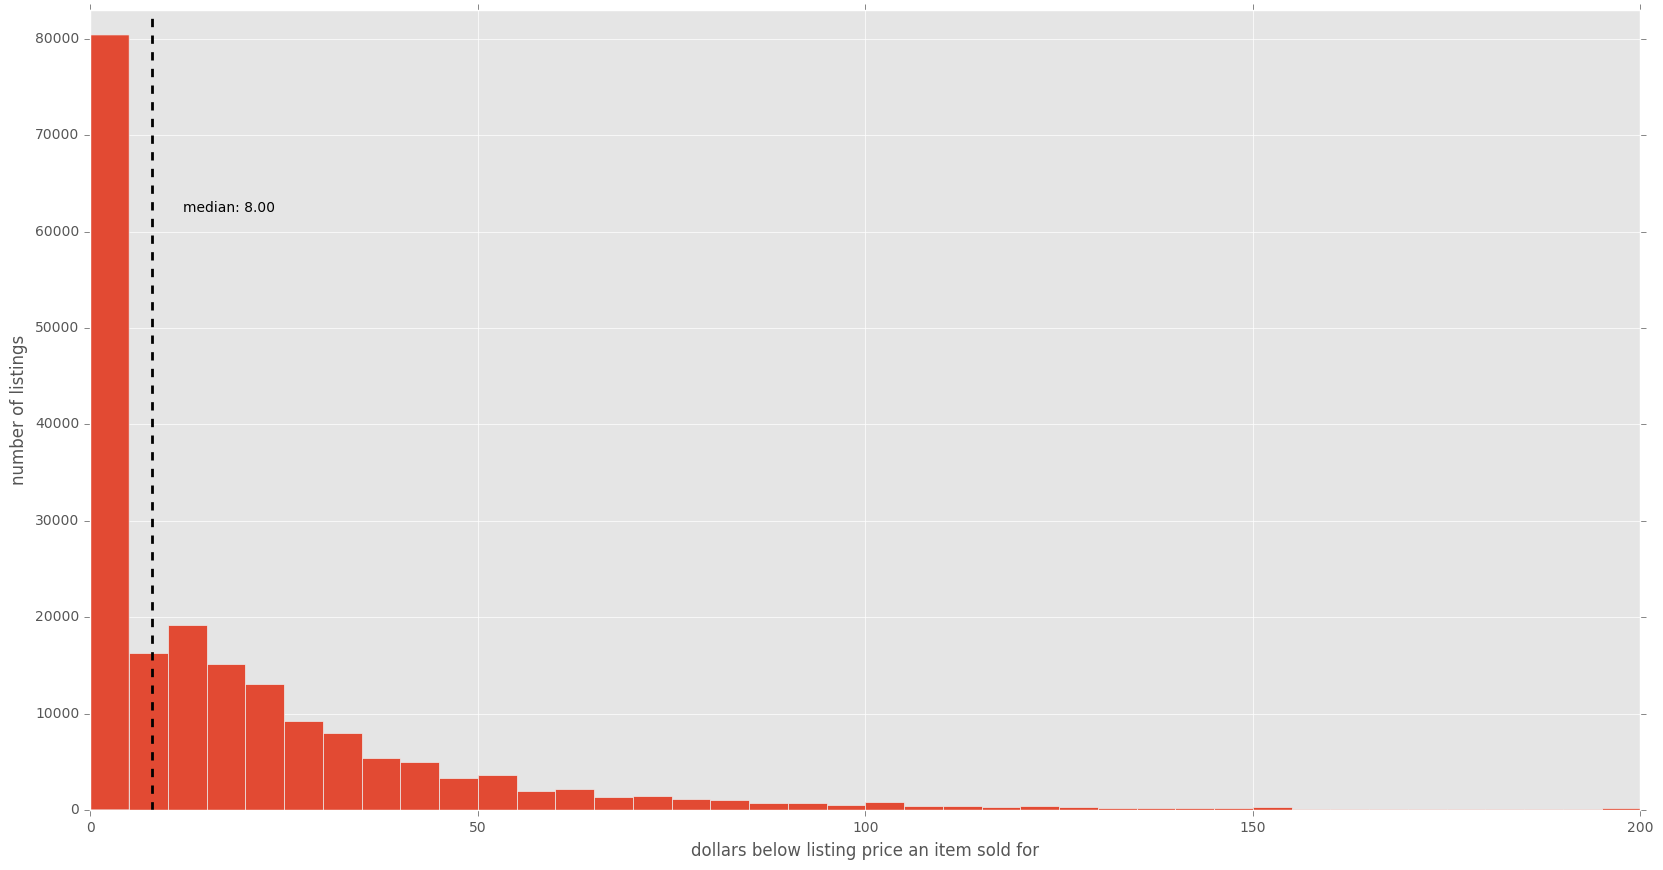

In [228]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sold_listings['lowball_amount'].hist(range=[0, 200], bins=40)
ax.set_ylim([0, 83000])
ax.set_ylabel('number of listings')
ax.set_xlabel('dollars below listing price an item sold for')

# draw median
lowball_amount_median = np.nanmedian(sold_listings['lowball_amount'])
plt.axvline(lowball_amount_median, color='black', linestyle='dashed', linewidth=2)
ax.text(12, 62000, 'median: {:.2f}'.format(lowball_amount_median), rotation=0)

***
This was super surprising to me. I've always taken the Grailed community to be a cesspool of extreme lowballers. It seems that the problem is isolated to being _sent_ lowball offers. Ultimately, sellers are still able to sell their listings for what they're asking for, with the majority of listings selling for over 91% of their listed price.

#### Overall Retail

Identifying retail prices was kind of tricky and this is (honestly) a pretty weak attempt. We basically cleaned the description and matched a (very) simple regex. There were about 30,000 listings with a match (non-trivial) and 919 of those listings with retail _below_ the listing price. I believe many of these to be errors, but there are some coveted items that command secondhand prices above retail (looking at you, Supreme).
***

In [6]:
listings_df['cleaned_description'] = listings_df['description'].str.lower().str.strip()
listings_df['cleaned_description'] = listings_df['cleaned_description'].str.replace(',', '').str.replace('.', '')
listings_df['cleaned_description'] = listings_df['cleaned_description'].str.replace('k', '000')
listings_df['retail'] = listings_df['cleaned_description'].str.extract('retail.{,10}?\$(\d+)', expand=True)
listings_df['retail'] = listings_df['retail'].apply(float)
listings_df['percent_of_retail'] = listings_df['price_plus_ship']/ listings_df['retail']
listings_with_retail_df = listings_df[np.isnan(listings_df['retail']) == False]
sold_listings = listings_df[listings_df['sold'] == 1]

In [9]:
len(listings_with_retail_df)

30093

In [7]:
len(listings_with_retail_df[(listings_with_retail_df['percent_of_retail'] > 1)][['description', 'price', 'retail']])

919

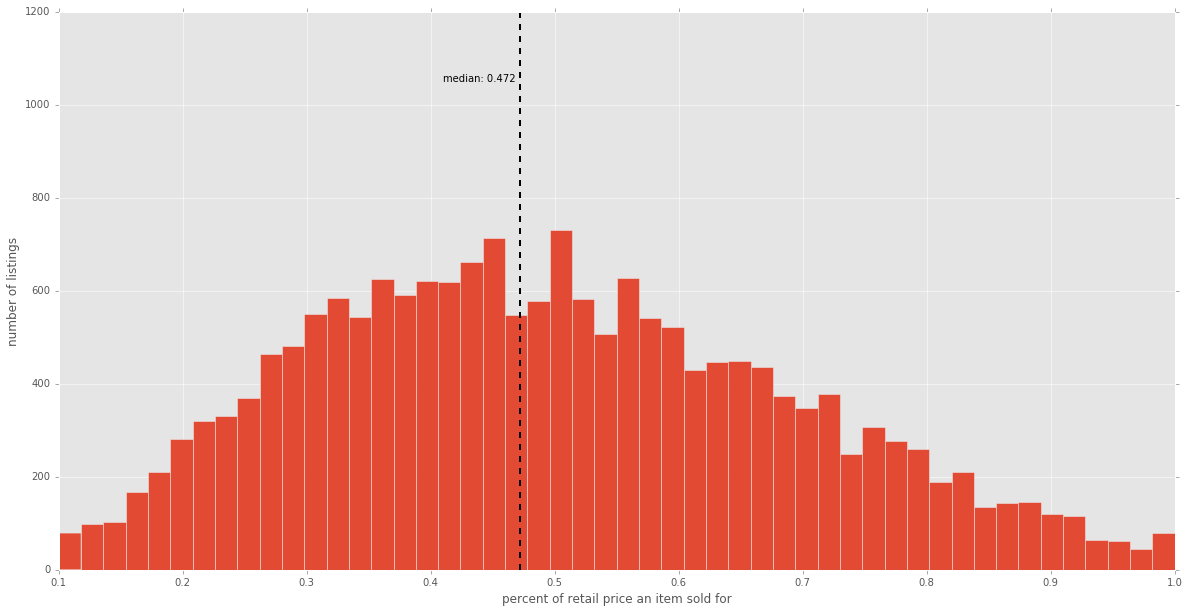

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sold_listings['percent_of_retail'].hist(range=[0.1, 1.0], bins=50)
ax.set_ylim([0, 1200])
ax.set_xlabel('percent of retail price an item sold for')
ax.set_ylabel('number of listings')

# draw median
percent_retail_median = np.nanmedian(sold_listings['percent_of_retail'])
plt.axvline(percent_retail_median, color='black', linestyle='dashed', linewidth=2)
ax.text(0.41, 1050, 'median: {:.3f}'.format(percent_retail_median), rotation=0)

***
Ignoring the potential error, it seems that half of listings are being sold below 47.2% of retail! That's fantastic (at least from a buyer's perspective). Grailed is an awesome place to grab great pieces for less.

#### Designer Retails

In [232]:
doi_with_retail = doi_averages[np.isnan(doi_averages['percent_of_retail']) == False]

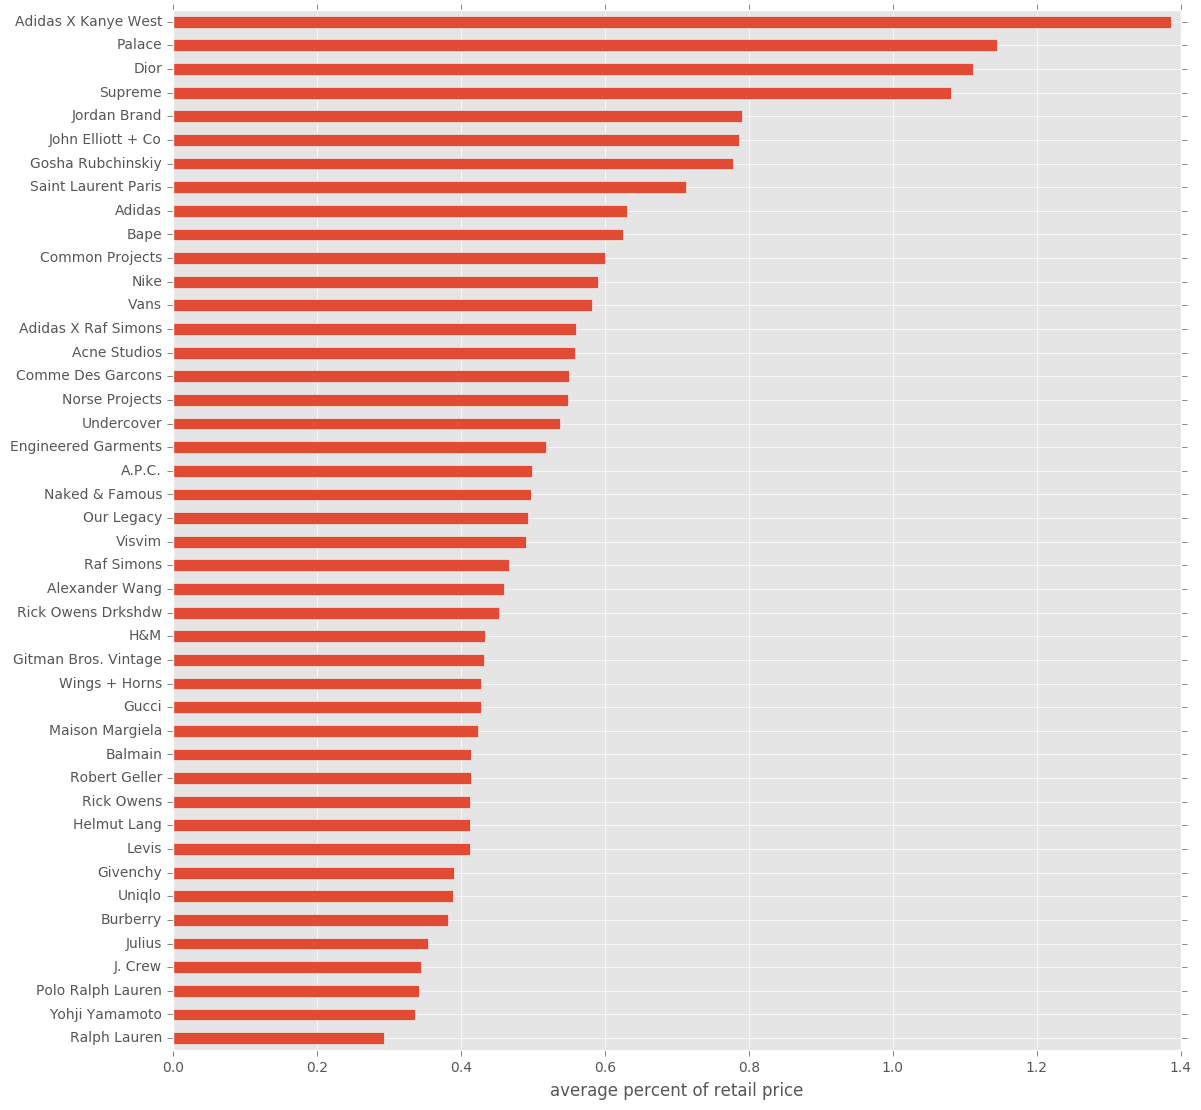

In [233]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 13)
doi_with_retail.sort_values(by='percent_of_retail')['percent_of_retail'].plot(kind='barh')
ax.set_ylabel('')
ax.set_xlabel('average percent of retail price')

***
This was meant to convey how well each designer retains its retail value. Yeezy, Supreme, Palace, and Dior seem to be selling over retail (hype, hype, hype). After that there's significant drop-off with the some popular brands retaining close to 80% of their retail value (yay John Eliott!). Some of the more expensive (retail-wise) designers can be found near the bottom, which is not surprising (there are a ton of steals on Grailed).

## Miscellaneous Distributions

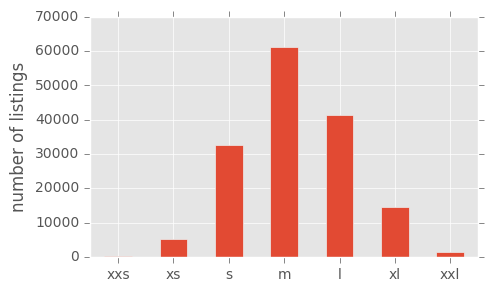

In [237]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 3)
tops_counts = listings_df[listings_df['category'].isin(['outerwear', 'tops'])].groupby('size').size()
tops_counts[['xxs', 'xs', 's', 'm', 'l', 'xl', 'xxl']].plot(kind='bar', rot=0)
ax.set_ylabel('number of listings')
ax.set_xlabel('')

***
I was under the impression smalls were the most common, but that appears to not be the case.
***

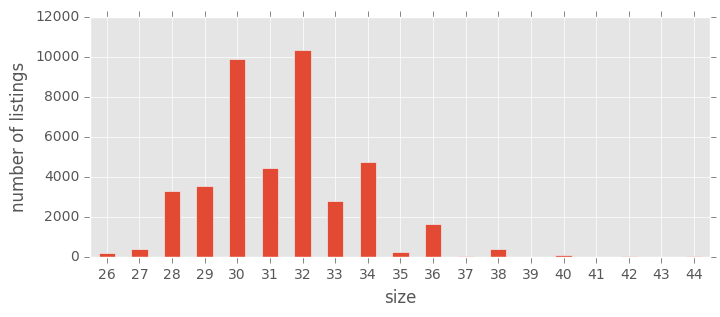

In [244]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
bottoms_counts = listings_df[listings_df['category'].isin(['bottoms', 'raw denim'])].groupby('size').size()
ax.set_ylabel('number of listings')
ax.set_xlabel('')
bottoms_counts[:-1].plot(kind='bar', rot=0)

***
No surprises here, the most common bottom sizes are 30 and 32.
***

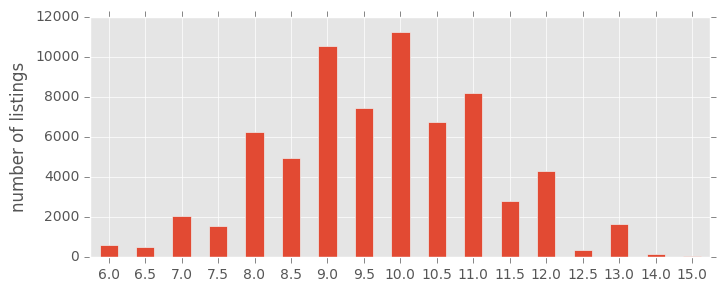

In [243]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
bottoms_counts = listings_df[listings_df['category'] == 'footwear'].groupby('size').size()
bottoms_counts = bottoms_counts.drop(['select a category'])
bottoms_counts.index = [float(i) for i in bottoms_counts.index.values]
bottoms_counts.sort_index().plot(kind='bar', rot=0)
ax.set_ylabel('number of listings')
ax.set_xlabel('')

***
Again, no surprises. 9 and 10 are the most common footwear sizes.
***

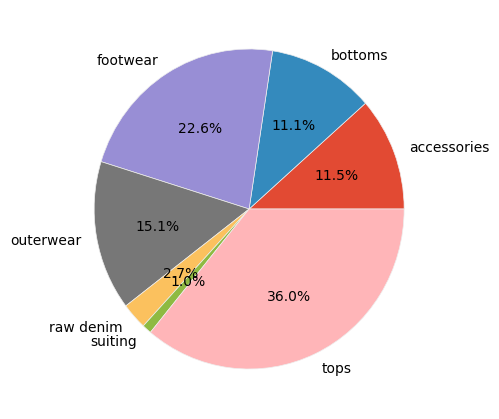

In [246]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
listings_df.groupby('category').size().plot(kind='pie', autopct='%1.1f%%')
ax.set_ylabel('')
ax.set_xlabel('')

***
There are so many different kinds of tops (tees, button-ups, sweaters, etc.). Raw denim and suiting being low make sense, as those are kind of niche categories. Maybe they should be absorbed into the other categories? Or perhaps Grailed should have sub-categories...

#### Grailed, Hype, and Basic

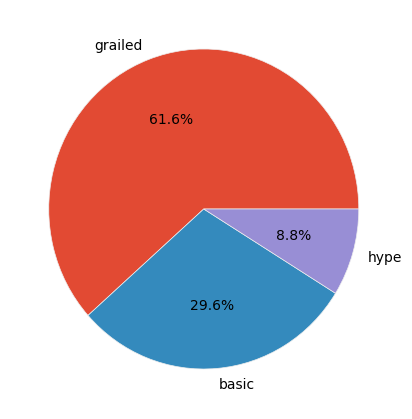

In [247]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
listings_df.groupby('strata').size()[['grailed', 'basic', 'hype']].plot(kind='pie', autopct='%1.1f%%')
ax.set_ylabel('')
ax.set_xlabel('')

***
Basic is surprisingly large to us. But that could be because we never browse it. :P